In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm

from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

In [2]:
import os
def load_data(directory):
    data = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            data.append(df)
    return pd.concat(data, ignore_index=True)

df = load_data('data/cic')
# Clean column names (in case of whitespace)
df.columns = df.columns.str.strip()

df = df[df['Label'] != 'BENIGN']

features = df.select_dtypes(include=[np.number]).copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
df = df.loc[features.index].copy()

100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
df["Label"].value_counts()

Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [5]:
df = df.loc[:, ~df.columns.str.contains('bwd', case=False)]
df = df.loc[:, ~df.columns.str.contains('backward', case=False)]


In [6]:
import pickle
with open('data/grouped_df.pkl', 'rb') as f:
    grouped_df = pickle.load(f)
grouped_df

,cic_Total Fwd Packets,cic_Total Length of Fwd Packets,cic_Fwd Packet Length Mean,cic_Fwd Packet Length Min,cic_Fwd Packet Length Max,cic_Fwd Packet Length Std,cic_Packet Length Variance,cic_Flow IAT Mean,cic_Flow IAT Std,cic_Flow IAT Min,...,dst_country_emb_2_first,dst_country_emb_3_first,dst_country_emb_4_first,dst_country_emb_5_first,dst_country_emb_6_first,dst_country_emb_7_first,dst_country_emb_8_first,dst_country_emb_9_first,cic_Fwd IAT Total,cic_Destination Port
0,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.001585,0.100905,-0.065801,0.297281,0.305936,-0.159620,0.116160,-0.044771,0,23
1,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.047310,-0.011996,0.005260,-0.025826,-0.004693,0.013444,0.013675,-0.007392,0,23
3,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.001585,0.100905,-0.065801,0.297281,0.305936,-0.159620,0.116160,-0.044771,0,23
4,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.105995,-0.107222,0.117179,-0.348651,0.276392,0.075724,-0.134629,0.061312,0,23
6,4.0,239.0,59.75,0.0,147.0,72.555151,5264.25,16.5,17.67767,4.0,...,-0.047310,-0.011996,0.005260,-0.025826,-0.004693,0.013444,0.013675,-0.007392,33,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381478,1.0,133.0,133.00,133.0,133.0,0.000000,0.00,0.0,0.00000,0.0,...,0.040023,0.056062,0.007198,0.258058,0.090996,-0.054872,0.113645,-0.099819,0,80
381479,1.0,97.0,97.00,97.0,97.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.087578,0.331180,-0.106147,-0.040069,-0.212324,0.055434,0.027325,0.007878,0,80
381480,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,0.098074,0.063331,-0.045459,-0.107533,-0.084309,-0.155936,-0.095196,-0.385889,0,23
381481,1.0,22.0,22.00,22.0,22.0,0.000000,0.00,0.0,0.00000,0.0,...,0.098074,0.063331,-0.045459,-0.107533,-0.084309,-0.155936,-0.095196,-0.385889,0,22


In [7]:
cic_columns = grouped_df.filter(regex='^cic').columns
grouped_df = grouped_df[[col for col in grouped_df.columns if 'emb' not in col]]
grouped_df_cic = grouped_df[cic_columns]

In [8]:
import pandas as pd

feature_mapping = [
    ('Destination Port', 'cic_Destination Port'),
    ('Flow Duration', 'cic_Flow Duration'),
    ('Total Fwd Packets', 'cic_Total Fwd Packets'),
    ('Total Length of Fwd Packets', 'cic_Total Length of Fwd Packets'),
    ('Fwd Packet Length Max', 'cic_Fwd Packet Length Max'),
    ('Fwd Packet Length Min', 'cic_Fwd Packet Length Min'),
    ('Fwd Packet Length Mean', 'cic_Fwd Packet Length Mean'),
    ('Fwd Packet Length Std', 'cic_Fwd Packet Length Std'),
    ('Flow Bytes/s', 'cic_Flow Bytes/s'),
    ('Flow Packets/s', 'cic_Flow Packets/s'),
    ('Flow IAT Mean', 'cic_Flow IAT Mean'),
    ('Flow IAT Std', 'cic_Flow IAT Std'),
    ('Flow IAT Max', 'cic_Flow IAT Max'),
    ('Flow IAT Min', 'cic_Flow IAT Min'),
    ('Fwd IAT Total', 'cic_Fwd IAT Total'),
    ('Fwd IAT Mean', 'cic_Fwd IAT Mean'),
    ('Fwd IAT Std', 'cic_Fwd IAT Std'),
    ('Fwd IAT Max', 'cic_Fwd IAT Max'),
    ('Fwd IAT Min', 'cic_Fwd IAT Min'),
    ('Fwd Packets/s', 'cic_Fwd Packets/s'),
    ('Min Packet Length', 'cic_Min Packet Length'),
    ('Max Packet Length', 'cic_Max Packet Length'),
    ('Packet Length Mean', 'cic_Packet Length Mean'),
    ('Packet Length Std', 'cic_Packet Length Std'),
    ('Packet Length Variance', 'cic_Packet Length Variance'),
    ('Average Packet Size', 'cic_Average Packet Size'),
    ('Avg Fwd Segment Size', 'cic_Avg Fwd Segment Size')
]

rename_dict = {cic_name: new_name for new_name, cic_name in feature_mapping}
grouped_df_cic.rename(columns=rename_dict, inplace=True)

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_15564\2195592805.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.rename(columns=rename_dict, inplace=True)


In [9]:
columns = list(grouped_df_cic.columns)
columns.append("Label")

In [10]:
df = df[columns]
df

,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Max,Fwd Packet Length Std,Packet Length Variance,Flow IAT Mean,Flow IAT Std,Flow IAT Min,...,Packet Length Std,Average Packet Size,Avg Fwd Segment Size,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Fwd IAT Total,Destination Port,Label
0,3,26,8.666667,0,20,10.263203,3.435231e+06,1.437547e+05,4.308658e+05,2,...,1853.437529,1163.300000,8.666667,3.735000e+02,5.239661e+02,744,3,747,80,DDoS
1,4,24,6.000000,6,6,0.000000,0.000000e+00,1.473794e+06,2.552043e+06,340,...,0.000000,7.500000,6.000000,1.473794e+06,2.552043e+06,4420639,340,4421382,80,DDoS
2,3,26,8.666667,0,20,10.263203,2.706820e+06,1.354422e+05,3.777253e+05,41,...,1645.241762,1291.888889,8.666667,6.491000e+03,8.165669e+03,12265,717,12982,80,DDoS
3,8,56,7.000000,0,20,5.656854,6.192667e+06,7.275851e+06,2.110000e+07,6,...,2488.507044,971.916667,7.000000,1.120000e+07,2.630000e+07,70600000,247,78700000,80,DDoS
4,3,26,8.666667,0,20,10.263203,4.572452e+06,8.033175e+04,2.268247e+05,3,...,2138.329153,1292.555556,8.666667,4.005000e+02,5.409367e+02,783,18,801,80,DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556551,8,326,40.750000,0,326,115.258405,7.361769e+06,9.593503e+05,2.262616e+06,1,...,2713.257986,919.846154,40.750000,9.301100e+05,2.460477e+06,6509948,1,6510770,80,DoS GoldenEye
556552,5,471,94.200000,0,471,210.637604,5.180836e+05,1.279258e+06,2.565153e+06,53,...,719.780257,399.600000,94.200000,1.628158e+06,3.255639e+06,6511616,176,6512631,80,DoS GoldenEye
556553,7,314,44.857143,0,314,118.680845,3.449144e+06,9.591001e+05,2.261842e+06,46,...,1857.187221,918.923077,44.857143,1.084509e+06,2.655701e+06,6505437,255,6507056,80,DoS GoldenEye
556554,8,369,46.125000,0,369,130.461201,7.358407e+06,9.590912e+05,2.262122e+06,47,...,2712.638403,923.153846,46.125000,9.296849e+05,2.458891e+06,6505926,168,6507794,80,DoS GoldenEye


In [11]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [12]:
df['Label'].value_counts()

Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [13]:
label_counts = df['Label'].value_counts()
labels_to_keep = label_counts[label_counts >= 1000].index
df = df[df['Label'].isin(labels_to_keep)].copy()

In [14]:
le = LabelEncoder()

df['label_encoded'] = le.fit_transform(df['Label'])
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")
print("\nUnique encoded values:", df['label_encoded'].unique())
print("Original labels:", df['Label'].unique())
df.drop(columns=["Label"], inplace=True)

Bot: 0
DDoS: 1
DoS GoldenEye: 2
DoS Hulk: 3
DoS Slowhttptest: 4
DoS slowloris: 5
FTP-Patator: 6
PortScan: 7
SSH-Patator: 8
Web Attack � Brute Force: 9

Unique encoded values: [1 7 0 9 6 8 5 4 3 2]
Original labels: ['DDoS' 'PortScan' 'Bot' 'Web Attack � Brute Force' 'FTP-Patator'
 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk'
 'DoS GoldenEye']


In [15]:
x = df.drop(columns=["label_encoded"])
y = df["label_encoded"]

x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(x,y, train_size=20000)

scaler = QuantileTransformer()
scaler.fit(x_labeled)
x_labeled = pd.DataFrame(scaler.transform(x_labeled), columns=x.columns)
x_unlabeled = pd.DataFrame(scaler.transform(x_unlabeled), columns=x.columns)

In [16]:
y_labeled.value_counts()

label_encoded
3    8281
7    5722
1    4617
2     348
6     288
5     210
8     202
4     188
0      78
9      66
Name: count, dtype: int64

# neural network

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from tensorflow.keras.layers import Dropout

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [19]:
class SelectiveConsistencyModel(tf.keras.Model):
    def __init__(self, base_model, lambda_consistency=0.3, noise_stddev=0.05):
        super().__init__()
        self.base_model = base_model
        self.lambda_consistency = lambda_consistency
        self.noise_stddev = noise_stddev
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        return self.base_model(inputs, training=training)

    def train_step(self, data):
        (x_batch, labeled_mask), y_batch, sample_weight = data

        pseudo_mask = tf.logical_not(labeled_mask)
        noise = tf.random.normal(tf.shape(x_batch), mean=0.0, stddev=self.noise_stddev)
        x_aug = tf.where(tf.expand_dims(pseudo_mask, -1), x_batch + noise, x_batch)

        with tf.GradientTape() as tape:
            pred = self(x_batch, training=True)

            labeled_mask_float = tf.cast(labeled_mask, tf.float32)
            loss_all = tf.keras.losses.sparse_categorical_crossentropy(y_batch, pred)

            # Combine both mask and weight into one effective weighting
            effective_weight = labeled_mask_float * sample_weight
            loss_supervised = tf.reduce_sum(loss_all * effective_weight) / (tf.reduce_sum(effective_weight) + 1e-8)

            # Consistency loss
            pred_aug = self(x_aug, training=True)
            consistency_mask = tf.cast(pseudo_mask, tf.float32)
            consistency_weight = tf.expand_dims(consistency_mask, -1)
            loss_consistency = tf.reduce_sum(tf.square(pred - pred_aug) * consistency_weight) / (tf.reduce_sum(consistency_mask) + 1e-8)

            total_loss = loss_supervised + self.lambda_consistency * loss_consistency

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.compiled_metrics.update_state(y_batch, pred)

        return {
            "loss": self.loss_tracker.result(),
            **{m.name: m.result() for m in self.metrics}
        }

    def test_step(self, data):
        x, y = data
        preds = self(x, training=False)
        loss = self.compute_loss(x, y, preds)
        for metric in self.metrics:
            metric.update_state(y, preds)

        return {
            "loss": loss,
            **{m.name: m.result() for m in self.metrics}
        }

In [20]:
def build_model(input_dim, num_classes=10, lambda_consistency=0.5, noise_stddev=0.02):
    inp = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512)(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    base_model = tf.keras.Model(inputs=inp, outputs=out)
    return SelectiveConsistencyModel(base_model, lambda_consistency, noise_stddev)

In [21]:
x_unlabeled = x_unlabeled.reset_index(drop=True)
y_unlabeled = y_unlabeled.reset_index(drop=True)

In [28]:
def train_with_curriculum(x_labeled, y_labeled, x_unlabeled, y_unlabeled_true=None,
                          n_iters=5, threshold_start=0.995, threshold_end=0.95,
                          lambda_schedule=None, noise_schedule=None, max_samples_per_step=5000):

    thresholds = np.linspace(threshold_start, threshold_end, n_iters)
    x_train_curr = x_labeled.copy()
    y_train_curr = y_labeled.copy()
    x_unlabeled_pool = x_unlabeled.copy()
    y_unlabeled_true_pool = y_unlabeled_true.copy() if y_unlabeled_true is not None else None

    samples_added_per_iter = []
    pseudo_eval_df = pd.DataFrame(index=x_unlabeled.index)
    pseudo_eval_df['true_label'] = y_unlabeled_true
    pseudo_eval_df['predicted_label'] = np.nan
    val_acc = []

    for step, curr_thresh in enumerate(thresholds):
        print(f"\n[Curriculum Step {step+1}] Threshold = {curr_thresh:.3f}")
        lambda_val = lambda_schedule[step] if lambda_schedule else 0.5
        noise_val = noise_schedule[step] if noise_schedule else 0.05

        print(f"→ λ = {lambda_val:.3f}, Noise STD = {noise_val:.3f}")

        model = build_model(input_dim=x_train_curr.shape[1],
                            lambda_consistency=lambda_val,
                            noise_stddev=noise_val)

        model.compile(optimizer='adam', metrics=['accuracy'])

        # Create a mask for labeled and pseudo-labeled data inorder to apply the consistency regularization to the unlabeled data only
        labeled_mask = np.concatenate([
            np.ones(len(x_labeled)),
            np.full(len(x_train_curr) - len(x_labeled), 0.3)  # pseudo-label weight
        ])

        # Convert to tensors

        x_tensor = tf.convert_to_tensor(x_train_curr.values, dtype=tf.float32)
        y_tensor = tf.convert_to_tensor(y_train_curr, dtype=tf.int32)
        mask_tensor = tf.convert_to_tensor(labeled_mask, dtype=tf.bool)

        sample_weights = compute_sample_weight('balanced', y=y_train_curr)
        sample_weights_tensor = tf.convert_to_tensor(sample_weights, dtype=tf.float32)

        train_dataset = tf.data.Dataset.from_tensor_slices(
            ((x_tensor, mask_tensor), y_tensor, sample_weights_tensor)
        ).shuffle(10000).batch(32)

        model.fit(train_dataset, epochs=10, verbose=1)

        if x_unlabeled_pool.empty:
            print("No unlabeled data left. Stopping early.")
            break

        pred_probs = model.predict(x_unlabeled_pool.values)
        pred_classes = np.argmax(pred_probs, axis=1)
        confidences = pred_probs.max(axis=1)

        # Compute entropy or confidence margin
        margin = pred_probs.max(axis=1) - np.partition(pred_probs, -2, axis=1)[:, -2]
        
        entropy = -np.sum(pred_probs * np.log(pred_probs + 1e-8), axis=1)
        entropy_mask = entropy < 0.3  # tune as needed

        high_conf_mask = (confidences >= curr_thresh) & (margin > 0.1)
        high_conf_mask = high_conf_mask & entropy_mask

        indices = np.where(high_conf_mask)[0]
        

        if len(indices) > max_samples_per_step:
            top_indices = np.argsort(confidences[indices])[-max_samples_per_step:]
            selected_indices = indices[top_indices]
        else:
            selected_indices = indices

        if len(selected_indices) == 0:
            print("→ No confident samples. Skipping this step.")
            continue

        x_high_conf = x_unlabeled_pool.iloc[selected_indices]
        y_high_conf = pred_classes[selected_indices]

        pseudo_eval_df.loc[x_high_conf.index, 'predicted_label'] = y_high_conf

        if y_unlabeled_true_pool is not None:
            y_true_new = y_unlabeled_true_pool.loc[x_high_conf.index]
            acc = accuracy_score(y_true_new, y_high_conf)
            print(f"→ Pseudo-label accuracy this step: {acc:.4f}")
            val_acc.append(acc)
            y_unlabeled_true_pool = y_unlabeled_true_pool.drop(index=x_high_conf.index)

        x_unlabeled_pool = x_unlabeled_pool.drop(index=x_high_conf.index)
        x_train_curr = pd.concat([x_train_curr, x_high_conf], axis=0)
        y_train_curr = np.concatenate([y_train_curr, y_high_conf], axis=0)

        samples_added_per_iter.append(len(y_high_conf))
        print(f"→ Added {len(y_high_conf)} pseudo-labeled samples (total: {len(x_train_curr)})")

    return thresholds[:len(samples_added_per_iter)], samples_added_per_iter, val_acc, pseudo_eval_df

In [29]:
def plot_curriculum_progress(thresholds, sample_counts, val_accuracies=None):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Confidence Threshold')
    ax1.set_ylabel('# Pseudo-Labeled Samples', color='blue')
    ax1.plot(thresholds, sample_counts, marker='o', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.invert_xaxis()

    if val_accuracies:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Validation Accuracy', color='green')
        ax2.plot(thresholds, val_accuracies, marker='s', linestyle='--', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Curriculum Learning Progress')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [33]:
n_iters = 8
lambda_schedule = np.linspace(0.4, 0.1, n_iters).tolist()
noise_schedule = np.linspace(0.01, 0.02, n_iters).tolist()

thresholds, counts, accs, eval_df = train_with_curriculum(
    x_labeled, y_labeled, x_unlabeled,
    y_unlabeled_true=y_unlabeled,
    n_iters=n_iters,
    lambda_schedule=lambda_schedule,
    noise_schedule=noise_schedule,
    max_samples_per_step=len(y_unlabeled)//n_iters
)

plot_curriculum_progress(thresholds, counts, accs)



[Curriculum Step 1] Threshold = 0.995
→ λ = 0.400, Noise STD = 0.010
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8007 - loss: 0.1314
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9290 - loss: 0.1081
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9520 - loss: 0.1041
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9586 - loss: 0.1037
Epoch 5/10
  1/625 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9375 - loss: 0.1054

KeyboardInterrupt: 

In [ ]:
eval_df.dropna(subset=['predicted_label'], inplace=True)
y_true_final = eval_df['true_label'].astype(int)
y_pred_final = eval_df['predicted_label'].astype(int)

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packag

              precision    recall  f1-score   support

           0       0.95      0.38      0.54      1884
           1       1.00      0.46      0.63    122746
           2       0.00      0.00      0.00      9777
           3       0.78      0.69      0.73    221329
           4       0.02      0.18      0.03      5287
           5       0.00      0.00      0.00      5080
           6       0.11      1.00      0.19      7634
           7       1.00      0.97      0.98    152616
           8       0.95      0.49      0.64      5666
           9       0.00      0.00      0.00      1387

    accuracy                           0.69    533406
   macro avg       0.48      0.42      0.38    533406
weighted avg       0.85      0.69      0.74    533406



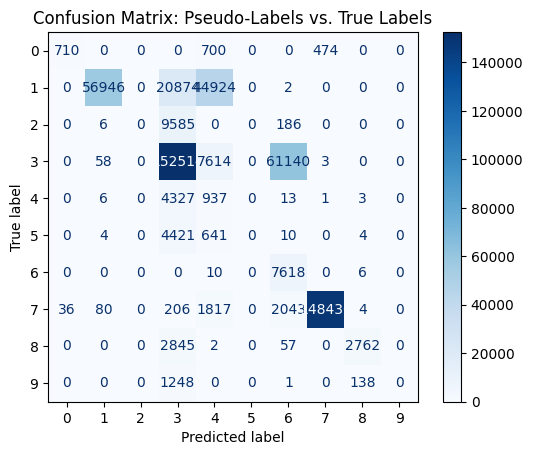

In [ ]:
print(classification_report(y_true_final, y_pred_final))

cm = confusion_matrix(y_true_final, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Pseudo-Labels vs. True Labels")
plt.show()


In [ ]:
class SelectiveConsistencyModel(tf.keras.Model):
    def __init__(self, base_model, lambda_consistency=0.3, noise_stddev=0.05):
        super().__init__()
        self.base_model = base_model
        self.lambda_consistency = lambda_consistency
        self.noise_stddev = noise_stddev
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        return self.base_model(inputs, training=training)

    def train_step(self, data):
        (x_batch, labeled_mask), y_batch = data

        pseudo_mask = tf.logical_not(labeled_mask)
        noise = tf.random.normal(tf.shape(x_batch), mean=0.0, stddev=self.noise_stddev)
        x_aug = tf.where(tf.expand_dims(pseudo_mask, -1), x_batch + noise, x_batch)

        with tf.GradientTape() as tape:
            pred = self(x_batch, training=True)
            labeled_mask_float = tf.cast(labeled_mask, tf.float32)
            loss_all = tf.keras.losses.sparse_categorical_crossentropy(y_batch, pred)
            loss_supervised = tf.reduce_sum(loss_all * labeled_mask_float) / (tf.reduce_sum(labeled_mask_float) + 1e-8)

            pred_aug = self(x_aug, training=True)
            consistency_mask = tf.cast(pseudo_mask, tf.float32)
            consistency_weight = tf.expand_dims(consistency_mask, -1)
            loss_consistency = tf.reduce_sum(tf.square(pred - pred_aug) * consistency_weight) / (tf.reduce_sum(consistency_mask) + 1e-8)

            total_loss = loss_supervised + self.lambda_consistency * loss_consistency

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.compiled_metrics.update_state(y_batch, pred)

        return {
            "loss": self.loss_tracker.result(),
            **{m.name: m.result() for m in self.metrics}
        }

    def test_step(self, data):
        x, y = data
        preds = self(x, training=False)
        loss = self.compute_loss(x, y, preds)
        for metric in self.metrics:
            metric.update_state(y, preds)

        return {
            "loss": loss,
            **{m.name: m.result() for m in self.metrics}
        }

In [ ]:
def build_model(input_dim, num_classes=10, lambda_consistency=0.5, noise_stddev=0.02):
    inp = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512)(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    base_model = tf.keras.Model(inputs=inp, outputs=out)
    return SelectiveConsistencyModel(base_model, lambda_consistency, noise_stddev)

In [ ]:
x_unlabeled = x_unlabeled.reset_index(drop=True)
y_unlabeled = y_unlabeled.reset_index(drop=True)

In [ ]:
def train_with_curriculum(x_labeled, y_labeled, x_unlabeled, y_unlabeled_true=None,
                          n_iters=5, threshold_start=0.995, threshold_end=0.95,
                          lambda_schedule=None, noise_schedule=None, max_samples_per_step=5000):

    thresholds = np.linspace(threshold_start, threshold_end, n_iters)
    x_train_curr = x_labeled.copy()
    y_train_curr = y_labeled.copy()
    x_unlabeled_pool = x_unlabeled.copy()
    y_unlabeled_true_pool = y_unlabeled_true.copy() if y_unlabeled_true is not None else None

    samples_added_per_iter = []
    pseudo_eval_df = pd.DataFrame(index=x_unlabeled.index)
    pseudo_eval_df['true_label'] = y_unlabeled_true
    pseudo_eval_df['predicted_label'] = np.nan
    val_acc = []

    for step, curr_thresh in enumerate(thresholds):
        print(f"\n[Curriculum Step {step+1}] Threshold = {curr_thresh:.3f}")
        lambda_val = lambda_schedule[step] if lambda_schedule else 0.5
        noise_val = noise_schedule[step] if noise_schedule else 0.05

        print(f"→ λ = {lambda_val:.3f}, Noise STD = {noise_val:.3f}")

        model = build_model(input_dim=x_train_curr.shape[1],
                            lambda_consistency=lambda_val,
                            noise_stddev=noise_val)

        model.compile(optimizer='adam', metrics=['accuracy'])

        # Create a mask for labeled and pseudo-labeled data inorder to apply the consistency regularization to the unlabeled data only
        labeled_mask = np.concatenate([
            np.ones(len(x_labeled)),
            np.full(len(x_train_curr) - len(x_labeled), 0.3)  # pseudo-label weight
        ])

        # Convert to tensors
        x_tensor = tf.convert_to_tensor(x_train_curr.values, dtype=tf.float32)
        y_tensor = tf.convert_to_tensor(y_train_curr, dtype=tf.int32)
        mask_tensor = tf.convert_to_tensor(labeled_mask, dtype=tf.bool)
        train_dataset = tf.data.Dataset.from_tensor_slices(((x_tensor, mask_tensor), y_tensor))
        train_dataset = train_dataset.shuffle(buffer_size=10000).batch(32)

        model.fit(train_dataset, epochs=10, verbose=1)

        if x_unlabeled_pool.empty:
            print("No unlabeled data left. Stopping early.")
            break

        pred_probs = model.predict(x_unlabeled_pool.values)
        pred_classes = np.argmax(pred_probs, axis=1)
        confidences = pred_probs.max(axis=1)

        # Compute entropy or confidence margin
        margin = pred_probs.max(axis=1) - np.partition(pred_probs, -2, axis=1)[:, -2]
        
        entropy = -np.sum(pred_probs * np.log(pred_probs + 1e-8), axis=1)
        entropy_mask = entropy < 0.3  # tune as needed

        high_conf_mask = (confidences >= curr_thresh) & (margin > 0.1)
        high_conf_mask = high_conf_mask & entropy_mask

        indices = np.where(high_conf_mask)[0]
        

        if len(indices) > max_samples_per_step:
            top_indices = np.argsort(confidences[indices])[-max_samples_per_step:]
            selected_indices = indices[top_indices]
        else:
            selected_indices = indices

        if len(selected_indices) == 0:
            print("→ No confident samples. Skipping this step.")
            continue

        x_high_conf = x_unlabeled_pool.iloc[selected_indices]
        y_high_conf = pred_classes[selected_indices]

        pseudo_eval_df.loc[x_high_conf.index, 'predicted_label'] = y_high_conf

        if y_unlabeled_true_pool is not None:
            y_true_new = y_unlabeled_true_pool.loc[x_high_conf.index]
            acc = accuracy_score(y_true_new, y_high_conf)
            print(f"→ Pseudo-label accuracy this step: {acc:.4f}")
            val_acc.append(acc)
            y_unlabeled_true_pool = y_unlabeled_true_pool.drop(index=x_high_conf.index)

        x_unlabeled_pool = x_unlabeled_pool.drop(index=x_high_conf.index)
        x_train_curr = pd.concat([x_train_curr, x_high_conf], axis=0)
        y_train_curr = np.concatenate([y_train_curr, y_high_conf], axis=0)

        samples_added_per_iter.append(len(y_high_conf))
        print(f"→ Added {len(y_high_conf)} pseudo-labeled samples (total: {len(x_train_curr)})")

    return thresholds[:len(samples_added_per_iter)], samples_added_per_iter, val_acc, pseudo_eval_df